In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
links = pd.read_csv('training/links (table 3).csv')
routes = pd.read_csv('training/routes (table 4).csv')
trajectories = pd.read_csv('training/trajectories(table 5)_training.csv')
volume = pd.read_csv('training/volume(table 6)_training.csv')
weather = pd.read_csv('training/weather (table 7)_training.csv')

submission = pd.read_csv('submission_sample_volume.csv')
test_volume = pd.read_csv('testing_phase1/volume(table 6)_test1.csv')
test_weather = pd.read_csv('testing_phase1/weather (table 7)_test1.csv')

In [3]:
def MAPE(preds, outputs):
    preds = np.array(preds)
    outputs = np.array(outputs)
    return np.average(np.abs(outputs - preds) / outputs)

# Feature Engineering 

## Part 1: Handle dates

In [4]:
def date_converter(volume, weather):
    # Initialize lists to store splitted information
    date_list = []
    month_list = []
    day_list = []
    hour_list = []
    minute_list = []
    rounded_min_list = []
    rounded_hour_list = []

    # Splits the 'time' information into month, day, hour and minute
    def date_spliter(date):
        counter = 0
        parts = date.split(" ")
        day_part = parts[0]
        clock_part = parts[1]

        day_parts = day_part.split("-")
        month = int(day_parts[1]) # Extract month from time
        day = int(day_parts[2]) # Extract day from time

        clock_parts = clock_part.split(":")
        hour = int(clock_parts[0]) # Extract hour from time
        minute = int(clock_parts[1]) # Extract minute from time

        rounded_hour = str(hour // 3 * 3)
        rounded_min = str(minute // 20 * 20)

        date_list.append(day_part)
        month_list.append(month)
        day_list.append(day)
        hour_list.append(hour)
        minute_list.append(minute)
        rounded_hour_list.append(rounded_hour)
        rounded_min_list.append(rounded_min)

    # Store info into lists
    for date in volume['time']:
        date_spliter(date)

    # Add arrays into the 'volume' SFrame
    volume['month'] = np.array(month_list)
    volume['day'] = np.array(day_list)
    volume['hour'] = np.array(hour_list)
    volume['minute'] = np.array(minute_list)
    volume['date'] = np.array(date_list)
    volume['rounded_hour'] = np.array(rounded_hour_list)
    volume['rounded_min'] = np.array(rounded_min_list)
    
    # Add an colume which combine 'date' and 'rounded_hour'
    print type(volume['date'][0])
    slash_list = np.array(['-'] * len(volume['date']))
    volume['date_and_rounded_hour'] = volume['date'] + slash_list + volume['rounded_hour']
    
    slash_list = np.array(['-'] * len(weather['date']))
    weather['date_and_rounded_hour'] = weather['date'] + slash_list + np.array([str(hour) for hour in weather['hour']])
    
    return (volume, weather)

### Apply function

In [5]:
(volume, weather) = date_converter(volume, weather)

<type 'str'>


## Part 2: Join tables

### a. Clean data

In [6]:
# Convert 'wind_direction' outlier to 360
weather.loc[weather['wind_direction'] > 360, 'wind_direction'] = 360

### b. Merge tables 

In [7]:
def build_merged_tables(volume, weather, join_type='inner'):
    # Merge 'volume' and 'weather' DataFrame together
    volume_weather = pd.merge(volume, weather, on='date_and_rounded_hour', suffixes=('', '_y'))

    # Construct 'window_time' list which uses date, hour, and rounded minute
    date_list = volume_weather['date'] + np.array(['-'] * len(volume_weather))
    hour_list = volume_weather['hour'].astype(str) + np.array(['-'] * len(volume_weather))
    window_time_list = date_list + hour_list + volume_weather['rounded_min']
    volume_weather['window_time'] = window_time_list
    
    return volume_weather

### Apply Function

In [8]:
volume_weather = build_merged_tables(volume, weather)

### c. Group data

In [9]:
# Group 'volume_weather' here
def group_vw(volume_weather):
    
    volume_weather = volume_weather.groupby(['window_time', 'tollgate_id', 'direction'])
    vwgrouped = volume_weather.agg('mean').join(pd.DataFrame(volume_weather.size(), columns=['count']))

    # Put index as column
    vwgrouped['direction'] = vwgrouped.index.get_level_values('direction')
    vwgrouped['tollgate_id'] = vwgrouped.index.get_level_values('tollgate_id')
    vwgrouped['window_time'] = vwgrouped.index.get_level_values('window_time')
    
    return vwgrouped

### Apply function

In [10]:
vwgrouped = group_vw(volume_weather)

### d. Data reconstruction

In [11]:
def re_construct_data(volume_weather):

    # Create 'weekday' column in DateFrame(0 stands for Sunday; 1 stands for Monday and 2 stands for Tuesday, etc...)
    sept = volume_weather[volume_weather['month'] == 9]
    weekday1 = ((sept['day'] + 3) % 7).values
    octo = volume_weather[volume_weather['month'] == 10]
    weekday2 = ((octo['day'] + 5) % 7).values
    volume_weather['weekday'] = np.append(weekday1, weekday2)
    
    # Create 'rounded_min' column
    volume_weather['rounded_min'] = volume_weather['minute'] // 20 * 20
    
    # Construc splitted numerical data column
    def split_value(df, column, values_list):
        for i in range(len(values_list) - 1):
            begin = values_list[i]
            end = values_list[i+1]
            new_column_name = column + "_" + str(begin) + "_" + str(end)
            df[new_column_name] = (df[column] >= begin).astype(int) & (df[column] < end).astype(int)
        return df
    
    # Create 'is_column_x' column in DataFrame
    def create_is_columns(df, column_names):
        for column_name in column_names:
            for i in np.sort(df[column_name].unique()):
                new_column_name = "is_" + column_name + "_" + str(i)
                df[new_column_name] = (df[column_name] == i).astype(int)
        return df

    start = datetime.now()
    is_columns = ['rounded_min', 'hour', 'tollgate_id', 'direction', 'weekday' ]
    create_is_columns(volume_weather, is_columns)
    end = datetime.now()
    print (end - start).seconds
    

    # Construct 'is_festival' column
    volume_weather['is_festival'] = np.array([0] * len(volume_weather))
    sep_days = [15, 16, 17]
    oct_days = [1, 2, 3, 4, 5, 6, 7]
    for day in sep_days:
        volume_weather.loc[((volume_weather['month'] == 9) & (volume_weather['day'] == day)), 'is_festival'] = 1
    for day in oct_days:
        volume_weather.loc[((volume_weather['month'] == 10) & (volume_weather['day'] == day)), 'is_festival'] = 1
        
    # Construct 'is_working_day' column
    volume_weather['is_working_day'] = np.array([0] * len(volume_weather))
    volume_weather.loc[((volume_weather['weekday'] < 5) & (volume_weather['weekday'] > 0)), 'is_working_day'] = 1
    volume_weather.loc[volume_weather['is_festival'] == 1, 'is_working_day'] = 0
    volume_weather.loc[((volume_weather['month'] == 9) & (volume_weather['day'] == 18)), 'is_working_day'] = 1
    volume_weather.loc[((volume_weather['month'] == 10)
                        & ((volume_weather['day'] == 8) | (volume_weather['day'] == 9))), 'is_working_day'] = 1
            
    # Normalized columns
    def normalize_columns(df, column_names):
        for column in column_names:
            new_column = "norm_" + column
            maxV = np.max(df[column])
            minV = np.min(df[column])
            df[new_column] = df[column].apply(lambda v : (v - minV) / (maxV - minV))
        return df
    
    start = datetime.now()
    to_norm = ['pressure', 'sea_pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 
                         'precipitation']
    volume_weather = normalize_columns(volume_weather, to_norm)
    end = datetime.now()
    print (end - start).seconds
    
    return volume_weather

### Apply function

In [12]:
vwgrouped = re_construct_data(vwgrouped)

0
0


In [13]:
# ignore 'vehicle_model', 'has_etc', 'norm_sea_pressure'here
my_features = ['norm_pressure', 'norm_wind_direction', 'norm_wind_speed', 'norm_temperature',
               'norm_rel_humidity', 'norm_precipitation',
               'is_working_day', 'is_festival',
               'is_rounded_min_0.0', 'is_rounded_min_20.0', 'is_rounded_min_40.0',
              'is_hour_1.0', 'is_hour_2.0', 'is_hour_3.0', 'is_hour_4.0', 'is_hour_5.0', 'is_hour_6.0',
               'is_hour_7.0', 'is_hour_8.0', 'is_hour_9.0', 'is_hour_10.0', 'is_hour_11.0', 'is_hour_12.0',
               'is_hour_13.0', 'is_hour_14.0', 'is_hour_15.0', 'is_hour_16.0', 'is_hour_17.0', 'is_hour_18.0',
               'is_hour_19.0', 'is_hour_20.0', 'is_hour_21.0', 'is_hour_22.0', 'is_hour_23.0', 'is_hour_0.0', 
              'is_tollgate_id_1', 'is_tollgate_id_2', 'is_tollgate_id_3', 'is_direction_0', 'is_direction_1', 
              'is_weekday_0.0', 'is_weekday_1.0','is_weekday_2.0','is_weekday_3.0','is_weekday_4.0','is_weekday_5.0','is_weekday_6.0',]

In [14]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectFromModel

# train_data = vwgrouped[my_features]
# clf = ExtraTreesClassifier()
# clf = clf.fit(train_data, vwgrouped['count'])

# imps = clf.feature_importances_
# imps = imps / sum(imps)

# dic = {}
# for i in range(len(imps)):
#     dic[imps[i]] = my_features[i]
# for key in sorted(dic, reverse=True):
#     print dic[key], "has weight:", "{0:.2f}".format(key)

## Create Test Set

In [15]:
# Best mape without splitting into 5 sets: 0.96349833440702359

In [16]:
# Construct test set
(test_volume, test_weather) = date_converter(test_volume, test_weather)
test_volume_weather = build_merged_tables(test_volume, test_weather)
test_vwgrouped = group_vw(test_volume_weather)
test_vwgrouped = re_construct_data(test_vwgrouped)

<type 'str'>
0
0


In [17]:
# Split training and validation set
training = vwgrouped[:8000]
validation = vwgrouped[8000:]

In [18]:
# Fill in missing columns in test set
for feature in my_features:
    if feature not in test_vwgrouped:
        test_vwgrouped[feature] = np.array([0] * len(test_vwgrouped))

In [19]:
# Split trining set into 5

train_sets = []
test_sets = []
for i in range(1, 4):
    for j in range(2):
        if ((i == 2) and (j == 1)): 
            break
        print i, j
        train_set = training[(training['tollgate_id'] == i) & (training['direction'] == j)]
        test_set = test_vwgrouped[(test_vwgrouped['tollgate_id'] == i) & (test_vwgrouped['direction'] == j)]
        train_sets.append(train_set)
        test_sets.append(test_set)

1 0
1 1
2 0
3 0
3 1


In [20]:
from sklearn import linear_model

In [21]:
preds = []
mapes = []
regs = []
from sklearn import linear_model
alphas = np.arange(0, 2, 0.01)
for a in alphas:
    reg = linear_model.Ridge(alpha=a)
    reg.fit(training[my_features], training['count'])
    regs.append(reg)
    pred = reg.predict(validation[my_features])
    preds.append(pred)
    mape = MAPE(pred, validation['count'])
    mapes.append(mape)

In [22]:
len(alphas)

200

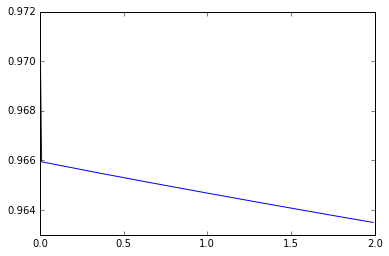

In [23]:
plt.plot(alphas, mapes)
plt.show()

In [24]:
print np.min(mapes)

0.963498334407


In [25]:
print np.argmin(mapes)

199


In [26]:
print mapes[:10]

[0.97177057051423865, 0.96594461477843507, 0.96593126061316581, 0.96591791398364257, 0.9659045748827858, 0.96589124330352727, 0.96587791923880606, 0.96586460268157437, 0.96585129362478939, 0.96583799206142218]


In [28]:
vwgrouped['time_window_formatted'] = pd.to_datetime(vwgrouped['window_time'], format='%Y-%m-%d-%M-%S')

In [29]:
id1direc0 = vwgrouped[(vwgrouped['tollgate_id'] == 1) & (vwgrouped['direction'] == 0)]

In [30]:
id1direc0['seq'] = np.array(range(len(id1direc0)))

C:\Users\THINKPAD\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


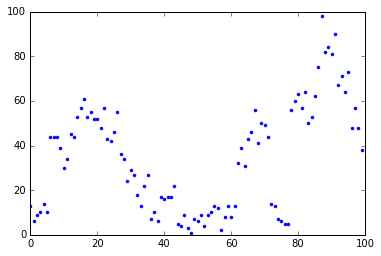

In [31]:
plt.plot(id1direc0['seq'][:100], id1direc0['count'][:100], '.')

In [32]:
len(vwgrouped)

9630

In [33]:
len(id1direc0)

1994

In [34]:
id1direc0 = id1direc0.sort(columns='time_window_formatted')

C:\Users\THINKPAD\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [35]:
id1direc0.head()

,,,vehicle_model,has_etc,vehicle_type,month,day,hour,minute,hour_y,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,count,direction,tollgate_id,window_time,weekday,rounded_min,is_rounded_min_0.0,is_rounded_min_20.0,is_rounded_min_40.0,is_hour_0.0,is_hour_1.0,is_hour_2.0,is_hour_3.0,is_hour_4.0,is_hour_5.0,is_hour_6.0,is_hour_7.0,is_hour_8.0,is_hour_9.0,is_hour_10.0,is_hour_11.0,is_hour_12.0,is_hour_13.0,is_hour_14.0,is_hour_15.0,is_hour_16.0,is_hour_17.0,is_hour_18.0,is_hour_19.0,is_hour_20.0,is_hour_21.0,is_hour_22.0,is_hour_23.0,is_tollgate_id_1,is_tollgate_id_2,is_tollgate_id_3,is_direction_0,is_direction_1,is_weekday_0.0,is_weekday_1.0,is_weekday_2.0,is_weekday_3.0,is_weekday_4.0,is_weekday_5.0,is_weekday_6.0,is_festival,is_working_day,norm_pressure,norm_sea_pressure,norm_wind_direction,norm_wind_speed,norm_temperature,norm_rel_humidity,norm_precipitation,time_window_formatted,seq
window_time,tollgate_id,direction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-19-0-0,1,0,1.692308,0.307692,NaN,9.0,19.0,0.0,11.923077,0.0,1008.2,1013.2,329.0,2.8,22.2,76.0,0.0,13,0,1,2016-09-19-0-0,1.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0.337662,0.339744,0.913649,0.373333,0.433155,0.607143,0.0,2016-09-19 00:00:00,0
2016-09-19-0-20,1,0,1.000000,0.166667,NaN,9.0,19.0,0.0,29.833333,0.0,1008.2,1013.2,329.0,2.8,22.2,76.0,0.0,6,0,1,2016-09-19-0-20,1.0,20.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0.337662,0.339744,0.913649,0.373333,0.433155,0.607143,0.0,2016-09-19 00:00:20,1
2016-09-19-0-40,1,0,1.888889,0.111111,NaN,9.0,19.0,0.0,49.000000,0.0,1008.2,1013.2,329.0,2.8,22.2,76.0,0.0,9,0,1,2016-09-19-0-40,1.0,40.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0.337662,0.339744,0.913649,0.373333,0.433155,0.607143,0.0,2016-09-19 00:00:40,2
2016-09-19-1-0,1,0,2.200000,0.100000,NaN,9.0,19.0,1.0,13.200000,0.0,1008.2,1013.2,329.0,2.8,22.2,76.0,0.0,10,0,1,2016-09-19-1-0,1.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0.337662,0.339744,0.913649,0.373333,0.433155,0.607143,0.0,2016-09-19 00:01:00,3
2016-09-19-1-20,1,0,1.428571,0.214286,NaN,9.0,19.0,1.0,27.000000,0.0,1008.2,1013.2,329.0,2.8,22.2,76.0,0.0,14,0,1,2016-09-19-1-20,1.0,20.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0.337662,0.339744,0.913649,0.373333,0.433155,0.607143,0.0,2016-09-19 00:01:20,4


In [36]:
?vwgrouped.save

Object `vwgrouped.save` not found.


In [37]:
?pd.save

Object `pd.save` not found.


In [38]:
?pd.DataFrame.to_csv

In [39]:
vwgrouped.to_csv("twenty_window_grouped.csv")

In [ ]:
(volume, weather) = date_converter(volume, weather)
# Convert 'wind_direction' outlier to 360
weather.loc[weather['wind_direction'] > 360, 'wind_direction'] = 360
volume_weather = build_merged_tables(volume, weather)
vwgrouped = group_vw(volume_weather)
vwgrouped = re_construct_data(vwgrouped)
vwgrouped = feature_engineering(vwgrouped)
trajectories = time_handler_traj(trajectories)
gp_traj = group_traj(trajectories)
(combi_in, combi_out) = create_combi(vwgrouped, gp_traj)
combi_in.to_csv("combi_in.csv")
combi_out.to_csv("combi_out.csv")